In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy
import vc_protocols

In [2]:
VC_protocol = vc_protocols.hERG_CiPA()
# VC_protocol = vc_protocols.cav12_CiPA()
# VC_protocol = vc_protocols.lateNav15_CiPA()

vhold = VC_protocol.steps[0].voltage

In [14]:
end_time = 1000# VC_protocol.get_voltage_change_endpoints()[-1]
bcl = 1000
duration = 0.5
offset = 20

cell_types = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
extra_log=['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ical.ICaNa', 'ical.ICaK', 'ikr.IKr', 'iks.IKs', 'ik1.IK1', 'inaca.INaCa', 'inacass.INaCa_ss', 'inak.INaK', 'ikb.IKb', 'inab.INab', 'icab.ICab', 'ipca.IpCa']

t_span = (0, end_time)
t_eval = np.linspace(0, t_span[1], 10000)  

In [15]:
start_time = time.time()

model, p, s = myokit.load("../mmt-model-files/ohara-cipa-v1-2017_VC.mmt")    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=vhold)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "ohara2017"  
params = {         
    'cell.mode': cell_types['Mid-myocardial'],    
}
sim.set_simulation_params(params)
y0 = sim.pre_simulate(5000, sim_type=1)
d = sim.simulate(end_time, log_times=None, extra_log=['membrane.i_ion'] + extra_log)

sol1 = {}
times1 = d['engine.time']
sol1["Voltage"] = VC_protocol.get_voltage_clamp_protocol(d['engine.time'])
sol1["I_total"] = d['membrane.i_ion']
sol1["I_Na"] = d['ina.INa']
sol1["I_Kr"] = d['ikr.IKr']
sol1["I_Ks"] = d['iks.IKs']
sol1["I_To"] = d['ito.Ito']
sol1["I_CaL"] = d['ical.ICaL']
sol1["I_K1"] = d['ik1.IK1']
sol1["I_NaL"] = d['inal.INaL']

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.736743450164795 seconds ---


In [16]:
start_time = time.time()

model, p, s = myokit.load("../mmt-model-files/ohara-cipa-v1-2017_JK-v1.mmt")    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=vhold)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "ohara2017"  

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.9392447471618652 seconds ---


In [22]:
start_time = time.time()
       
params = {         
    'cell.mode': cell_types['Mid-myocardial'],
    'setting.simType': 1,   # 0: AP   |  1: VC  
    
    'ina.gNa' : 75.0,   
    'inal.gNaL' : 0.0075 * 2.661,  
    'ito.gto' : 0.02,
    'ical.PCa' : 0.0001 * 1.007,
    'ikr.gKr' : 4.65854545454545618e-2, # [mS/uF]
    'iks.gKs' : 0.0034 * 1.87,
    'ik1.gK1' : 0.1908 * 1.698,
    'inaca.gNaCa' : 0.0008,
    'inak.PNaK' : 30,
    'ikb.gKb' : 0.003,
    'inab.PNab' : 3.75e-10,
    'icab.PCab' : 2.5e-8,
    'ipca.GpCa' : 0.0005,

    'ina.g_adj' : 1,  
    'inal.g_adj' : 1,
    'ito.g_adj' : 4,
    'ical.g_adj' : 2.5,
    'ikr.g_adj' : 0.8,
    'iks.g_adj' : 1,
    'ik1.g_adj' : 1.3,
    'inaca.g_adj' : 1.4,
    'inak.g_adj' : 0.7,
    'ikb.g_adj' : 1,
    'inab.g_adj' : 1,
    'icab.g_adj' : 1,
    'ipca.g_adj' : 1, 
}
sim.set_simulation_params(params)

# sim.set_initial_values([-88] + y0)
sim.pre_simulate(5000, sim_type=1)
d = sim.simulate(end_time, log_times=None , extra_log=['membrane.VC', 'membrane.i_ion'] + extra_log)

sol2 = {}
times2 = d['engine.time']
sol2["Voltage"] = d['membrane.VC']
sol2["I_total"] = d['membrane.i_ion']
sol2["I_Na"] = sim.current_response_info.get_current(['INa'])
sol2["I_Kr"] = sim.current_response_info.get_current(['IKr'])
sol2["I_Ks"] = sim.current_response_info.get_current(['IKs'])
sol2["I_To"] = sim.current_response_info.get_current(['Ito'])
sol2["I_CaL"] = sim.current_response_info.get_current(['ICaL'])
sol2["I_K1"] = sim.current_response_info.get_current(['IK1'])
sol2["I_NaL"] = sim.current_response_info.get_current(['INaL'])

print("--- %s seconds ---"%(time.time()-start_time))

--- 0.18412351608276367 seconds ---


In [23]:
# from ord2017 import ORD2017
# start_time = time.time()

# protocol = protocol_lib.PacingProtocol(level=1, start=offset, length=duration, period=bcl*100, multiplier=0, default_time_unit='ms')
# model = ORD2017(protocol, is_exp_artefact=False)
# sim = simulator_scipy.Simulator(model)
# sim.model.change_cell(2)  

# # sim.model.ina.G_adj = 1   
# # sim.model.inal.G_adj = 1
# # sim.model.ito.G_adj = 1
# # sim.model.ical.G_adj = 1
# # sim.model.ikr.G_adj = 1
# # sim.model.iks.G_adj = 1
# # sim.model.ik1.G_adj = 1
# # sim.model.inaca.G_adj = 1
# # sim.model.inak.G_adj = 1
# # sim.model.ikb.G_adj = 1
# # sim.model.inab.G_adj = 1
# # sim.model.icab.G_adj = 1
# # sim.model.ipca.G_adj = 1

# # y0 = sim.pre_simulate( protocol='constant', pre_step=bcl*100, v0=-87 )   
# sim.model.y0[:-1] = y0
# d = sim.simulate(t_span=[0, end_time], t_eval=None, method='BDF', max_step=0.5, atol=1e-6, rtol=1e-6) # 1e-12, 1e-14  # 1e-08, 1e-10
     
# sol2 = {}
# times2 = d.t
# sol2["Voltage"] = d.y[0]
# sol2["I_Na"] = sim.model.current_response_info.get_current(['I_Na'])
# sol2["I_Kr"] = sim.model.current_response_info.get_current(['I_Kr'])
# sol2["I_Ks"] = sim.model.current_response_info.get_current(['I_Ks'])
# sol2["I_To"] = sim.model.current_response_info.get_current(['I_To'])
# sol2["I_CaL"] = sim.model.current_response_info.get_current(['I_CaL'])
# sol2["I_K1"] = sim.model.current_response_info.get_current(['I_K1'])
# sol2["I_NaL"] = sim.model.current_response_info.get_current(['I_NaL'])
# I_total = np.zeros_like(times2)
# for i, (name, values) in enumerate(sol2.items()):   
#     if i != 0:
#         I_total += values
# sol2["I_total"] = I_total
     
# tr = mod_trace.Trace(protocol,
#                  cell_params=None,
#                  t=d.t,
#                  y=d.y[0, :], 
#                  command_voltages=d.y[0, :],
#                  current_response_info=sim.model.current_response_info,
#                  default_unit=None)     
    
# current_contributions = tr.current_response_info.get_current_contributions( time=tr.t, window=10, step_size=5)
# max_contributions = tr.current_response_info.get_max_current_contributions(tr.t, window=10, step_size=5)
# print("--- %s seconds ---"%(time.time()-start_time))

In [24]:
# max_contributions

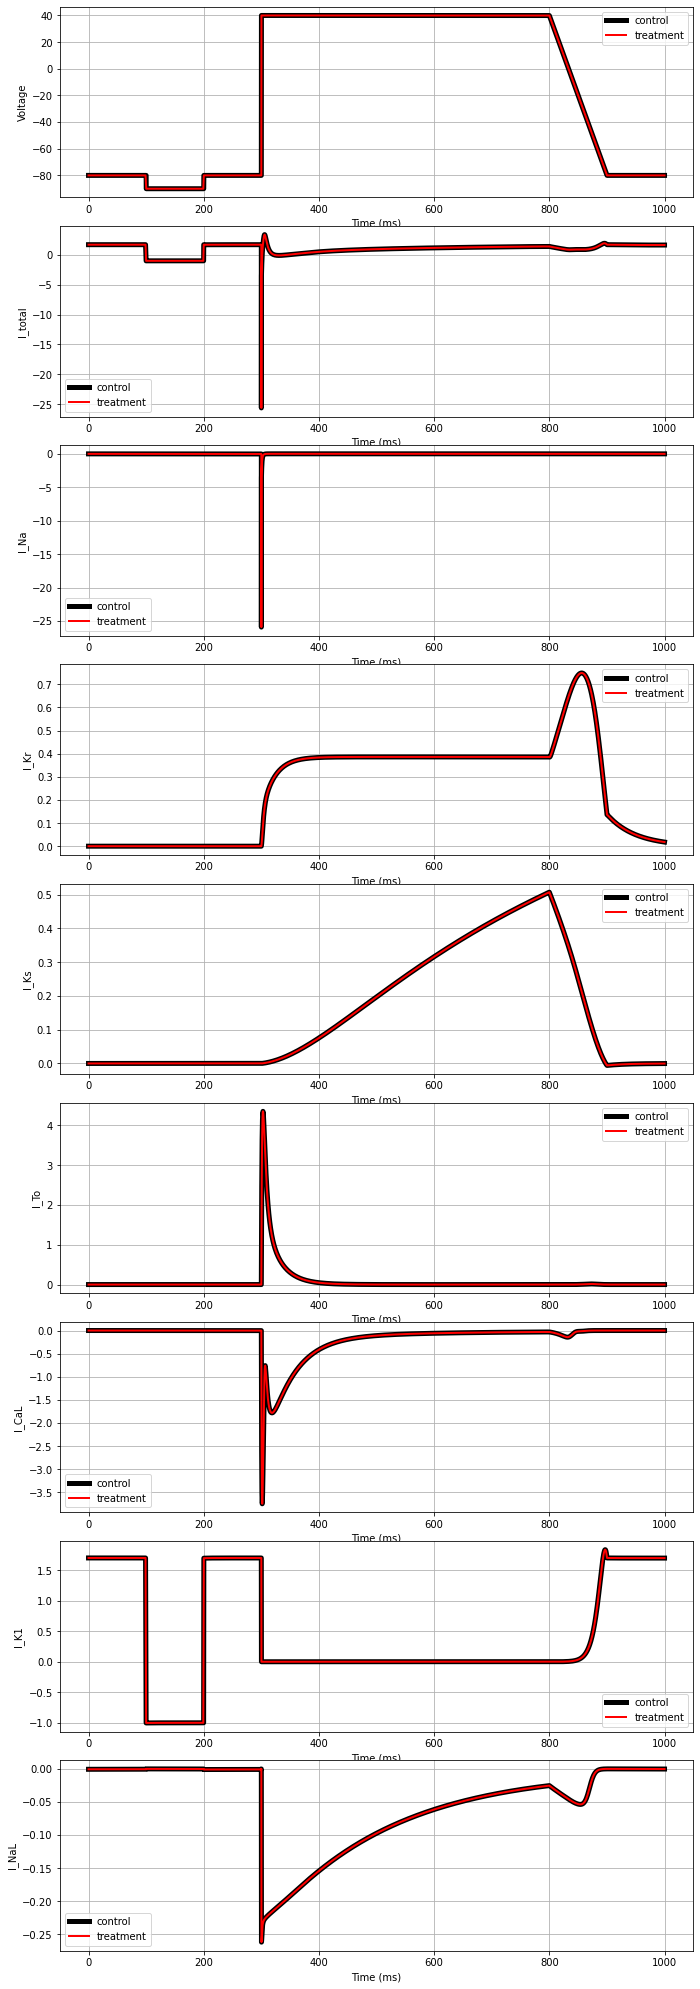

In [25]:
'''
Plot
'''
fig, ax = plt.subplots(len(sol1),1, figsize=(10,30))    
# fig.suptitle(sim.name, fontsize=14)
for i, (name, values) in enumerate(sol1.items()):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax[i].set_xlabel('Time (ms)')       
    ax[i].set_ylabel(f'{name}')      
    ax[i].plot( times1, values, label='control', color='k', linewidth=5)     
    ax[i].plot( times2, sol2[name], label='treatment', color='r', linewidth=2)    
    ax[i].legend()
    ax[i].grid()

# ax[-1].set_ylim(-5, 5)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
# fig.savefig(os.path.join('Results', "C.jpg"), dpi=100)